<a href="https://colab.research.google.com/github/muhammadnouman911/Pretrained-model-for-Audio-Classification/blob/main/Pretrained_Model_(YAMNet)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESC-50 Audio Classification with Pretrained Model (YAMNet) and Web Interface


 ============================================
# STEP 1: INSTALL REQUIRED LIBRARIES
 ============================================

In [ ]:
!pip install librosa matplotlib pandas scikit-learn tensorflow gradio tensorflow_hub --quiet


 ============================================
# STEP 2: IMPORT LIBRARIES
 ============================================

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import IPython.display as ipd
from io import BytesIO
from PIL import Image
import librosa
import tensorflow_hub as hub
import tensorflow as tf
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import gradio as gr

 ============================================
# STEP 3: MOUNT GOOGLE DRIVE
 ============================================

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ============================================
# STEP 4: SET PATHS
 ============================================

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ESC-50/ESC-50-master'
AUDIO_PATH = DATA_PATH + '/audio'
META_PATH = DATA_PATH + '/meta/esc50.csv'

 ============================================
# STEP 5: LOAD METADATA
 ============================================

In [ ]:
metadata = pd.read_csv(META_PATH)
print("Total Samples:", len(metadata))
metadata.head()


Total Samples: 2000


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


 ============================================
# STEP 6: FEATURE EXTRACTION USING YAMNet
 ============================================
# Download pretrained YAMNet model

In [ ]:
# Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')


# Function to extract log-mel spectrogram and use YAMNet

In [ ]:
def extract_yamnet_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # Ensure at least 1 second of audio
    if y.shape[0] < sr:
        y = np.pad(y, (0, sr - y.shape[0]), mode='constant')
    else:
        y = y[:sr]  # Truncate if longer than 1 second

    waveform = tf.convert_to_tensor(y, dtype=tf.float32)  # Don't reshape to (1, -1)

    # Run through YAMNet
    scores, embeddings, spectrogram = yamnet_model(waveform)

    # Return the mean embedding
    return tf.reduce_mean(embeddings, axis=0).numpy()

# Dataset feature extraction
X, y = [], []

for i, row in metadata.iterrows():
    try:
        file_path = os.path.join(AUDIO_PATH, row['filename'])
        label = row['category']
        features = extract_yamnet_features(file_path)
        X.append(features)
        y.append(label)
    except Exception as e:
        print(f"❌ Error in file: {row['filename']} | {str(e)}")

X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=test_size, random_state=42, stratify=y_cat)


# STEP 7: CLASSIFIER ON TOP OF YAMNet FEATURES


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(50, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,706 (557.45 KB)

 Trainable params: 142,706 (557.45 KB)

 Non-trainable params: 0 (0.00 B)

 ============================================
# STEP 8: TRAIN MODEL
 ============================================

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stop])


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0670 - loss: 3.8330 - val_accuracy: 0.4375 - val_loss: 3.0619
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3048 - loss: 2.9535 - val_accuracy: 0.5825 - val_loss: 1.9632
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4472 - loss: 2.1861 - val_accuracy: 0.6575 - val_loss: 1.4919
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5537 - loss: 1.6950 - val_accuracy: 0.6975 - val_loss: 1.2537
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5837 - loss: 1.4879 - val_accuracy: 0.6875 - val_loss: 1.1926
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6340 - loss: 1.3464 - val_accuracy: 0.7200 - val_loss: 1.0737
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6712 - loss: 1.2252 - val_accuracy: 0.7375 - val_loss: 1.0582
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7000 - loss: 1.1514 - val_accuracy: 0.7300 - val_loss

# STEP 9: EVALUATE & PLOT RESULTS


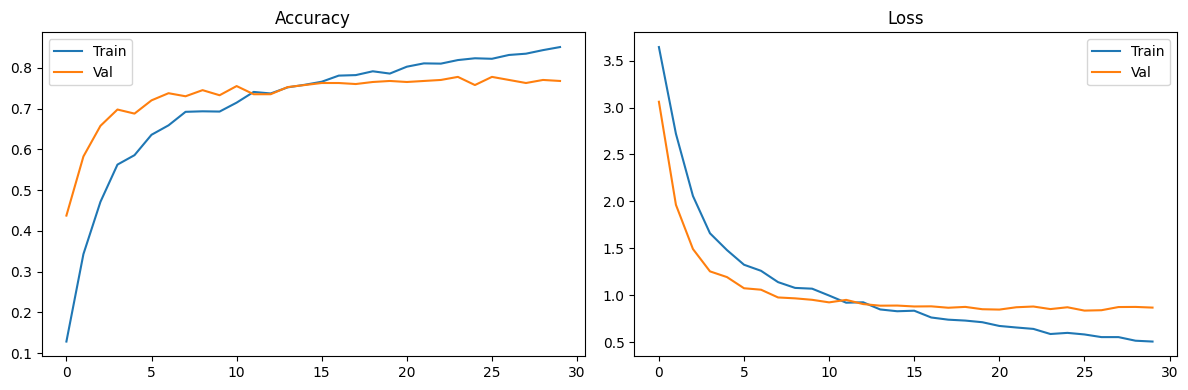

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final accuracy

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {acc*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7589 - loss: 0.9022 
Final Test Accuracy: 77.75%


 ============================================
# STEP 10: PREDICT ON CUSTOM FILE
 ============================================

In [ ]:
def predict_file(file_path):
    features = extract_yamnet_features(file_path)
    features = features[np.newaxis, ...]  # add batch dim
    prediction = model.predict(features)
    class_index = np.argmax(prediction)
    return le.classes_[class_index]

# ============================================
# STEP 11: GENERATE MEL SPECTROGRAM IMAGE
# ============================================

In [ ]:
def generate_spectrogram_image(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    if y.shape[0] < sr:
        y = np.pad(y, (0, sr - y.shape[0]), mode='constant')
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return Image.open(buf)

# ============================================
# STEP 12: GRADIO WEB INTERFACE
# ============================================

In [ ]:
def classify_audio_gradio(file_path):
    pred = predict_file(file_path)
    spectrogram_img = generate_spectrogram_image(file_path)
    return f"Predicted class: {pred}", spectrogram_img

audio_interface = gr.Interface(
    fn=classify_audio_gradio,
    inputs=gr.Audio(type="filepath"),
    outputs=[
        gr.Text(label="Predicted Class"),
        gr.Image(label="Mel Spectrogram")
    ],
    title="ESC-50 Audio Classifier (YAMNet)",
    description="Upload a .wav audio file to classify its environmental sound category and see its mel spectrogram."
)

audio_interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://de276b30bf36db181d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
